# Quant trading strategy: Dow Jones Industrial Average

### The objective is to come up with monthly trading strategy 

### On the first trading day of each month we want to decide whether to go long or short

In [1]:
import math
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')

from datetime import datetime
import pandas_datareader.data as web
import quandl

# Step 1: Get Data

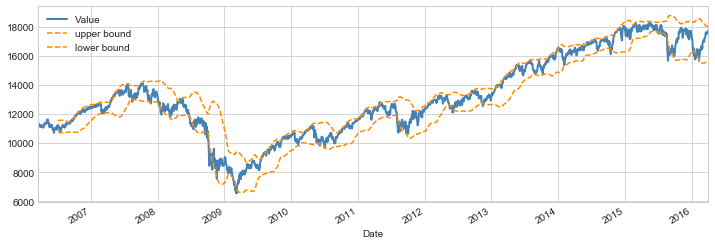

In [2]:
spy = quandl.get('BCB/UDJIAD1',start_date='2006-03-20',end_date='2016-03-31')
spy.plot(color="steelblue",lw=2,figsize=(12,4),label="stock price")
plt.plot(spy['Value'].rolling(75).mean()+2 * spy['Value'].rolling(75).std(),color="darkorange",ls='--',label="upper bound")
plt.plot(spy['Value'].rolling(75).mean()-2 * spy['Value'].rolling(75).std(),color="darkorange",ls='--',label="lower bound")
plt.legend()

# Step 2: Compute the daily log returns

In [3]:
#Log return = ln(P today / P yesterday)
df1 = spy.copy()
df1.reset_index(level=0, inplace=True)
df1 = df1.sort_values('Date',ascending=False)
df1['Value_1'] = df1['Value'].shift(-1)
df1.dropna(inplace=True)
df1['Daily Log Returns'] = np.log(df1['Value'] / df1['Value_1'])

# Step 3: Compute the daily momentum over last 75 days

In [4]:
#Momentum = sum of returns / standard deviation 
#This will tell us the trend of returns of the last 75 days and adjust any spikes 
df1 = df1.sort_values('Date')
df1['Last 75 Days Sum'] = df1['Daily Log Returns'].rolling(75).sum()
df1['Last 75 days sd'] = df1['Daily Log Returns'].rolling(75).std()
df1['Last_75_Sum_1'] = df1['Last 75 Days Sum'].shift(1)
df1['Last_75_Sd_1'] = df1['Last 75 days sd'].shift(1)
df1['Momentum'] = df1['Last_75_Sum_1'] / df1['Last_75_Sd_1']

# Step 4: Compute the monthly long/short signal

In [5]:
#Filter this data on monthly time series 
#Computing Z-score of the momentum 
#Z-score normalizes the momentum so that we can compare it across different months 
#Strategy returns = actual returns * signal 
df1['month'] = df1['Date'].apply(lambda x: x.month)
df1['month_1'] = df1['month'].shift(1)
df2 = df1[df1['month'] != df1['month_1']].copy()
df2['Value_1'] = df2['Value'].shift(1)
df2.dropna(inplace=True)
df2['Mon Log Returns'] = np.log(df2['Value'] / df2['Value_1'])

In [6]:
df2['Last 24 Days Mean'] = df2['Momentum'].rolling(24).mean()
df2['Last 24 days Sd'] = df2['Momentum'].rolling(24).std()
df2['Last_24_Sum_1'] = df2['Last 24 Days Mean'].shift(1)
df2['Last_24_Sd_1'] = df2['Last 24 days Sd'].shift(1)
df2['MomZscore'] = (df2['Momentum'] - df2['Last_24_Sum_1']) / df2['Last_24_Sd_1']
df2['MomSignal'] = df2['MomZscore'].shift(1)
df2['Mom Returns'] = df2['Mon Log Returns'] * df2['MomSignal']

In [7]:
datecond = datetime(2008, 10, 1)
df3 = df2[df2['Date'] >= datecond].copy()
sharpe = np.mean(df3['Mom Returns']) / np.std(df3['Mom Returns']) * (12**0.5)
print("sharpe: ",round(sharpe,3))

sharpe:  0.156


# Step 5: Jump Factor

In [8]:
#Building a strategy using a jump factor 
#This measure if there is a spike in last 2 months compared to the last 2 years 
#We want to bet in reverse direction 
df2['Last 2 Days Mean'] = df2['Mon Log Returns'].rolling(2).mean()
df2['Last 24 Days Mean'] = df2['Mon Log Returns'].rolling(24).mean()
df2['Last 24 days Sd'] = df2['Mon Log Returns'].rolling(24).std()
df2['Last_2_Sum_1'] = df2['Last 2 Days Mean'].shift(1)
df2['Last_24_Sum_1'] = df2['Last 24 Days Mean'].shift(1)
df2['Last_24_Sd_1'] = df2['Last 24 days Sd'].shift(1)
df2['Jump'] = (df2['Last_2_Sum_1'] - df2['Last_24_Sum_1']) / df2['Last_24_Sd_1']
df2['Jump Signal'] = -1  * df2['Jump']
df2['Jump Returns'] = df2['Mon Log Returns'] * df2['Jump Signal']

In [9]:
datecond = datetime(2008, 10, 1)
df3 = df2[df2['Date'] >= datecond].copy()
sharpe = np.mean(df3['Jump Returns']) / np.std(df3['Jump Returns']) * (12**0.5)
print("sharpe: ",round(sharpe,3))

sharpe:  0.269


# Step 6: Combined trading strategy

In [10]:
#Usually trading strategies use more than 1 factor 
#We can use weighted average of momentum and jump 
#Used LP to get the weights 
df3['MomWeight'] = 0.45 * df3['MomSignal']
df3['JumpWeight'] = 0.55 * df3['Jump Signal']
df3['Combined Signal'] = df3['MomWeight'] + df3['JumpWeight']
df3['Combined Returns'] = df3['Mon Log Returns'] * df3['Combined Signal']

In [11]:
sharpe = np.mean(df3['Combined Returns']) / np.std(df3['Combined Returns']) * (12**0.5)
print("sharpe: ",round(sharpe,3))

sharpe:  0.549


# Step 7: Compare with Excel 